In [2]:
import requests
import pandas as pd
import os
import seaborn as sns
import json
import numpy as np

In [3]:
path = './nessus_csv'
pd.set_option('display.max_colwidth', 0)

In [5]:
nessusfiles = []
with os.scandir(path) as listofentries:
    for entry in listofentries:
        if entry.is_file():
            nessusfiles.append(entry.name)

In [6]:
nessusdate_str=[]
for entrylist in nessusfiles:
    nessusdate_str.append(entrylist[0:10])

### FUNCTION: Query circl.lu and Enrich CVE Information

In [7]:
def circl_cve(thecve):
    r = requests.get('https://cve.circl.lu/api/cve/'+thecve, timeout=None)
    r = r.json()
    print(type(r))
    if r is None:
        r_access_auth = np.nan
        r_access_plex = np.nan
        r_access_vect = np.nan
        r_cwe = np.nan
        r_impact_avail = np.nan
        r_impact_conf = np.nan
        r_impact_integ = np.nan
    else:
        #r = r.json()
        r_access = r['access']
        r_access_auth = r_access['authentication']
        r_access_plex = r_access['complexity']
        r_access_vect = r_access['vector']
        r_cwe = r['cwe']
        r_impact = r['impact']
        r_impact_avail = r_impact['availability']
        r_impact_conf = r_impact['confidentiality']
        r_impact_integ = r_impact['integrity']
    return(thecve,r_cwe,r_access_auth,r_access_plex,r_access_vect,r_impact_avail,r_impact_conf,r_impact_integ)

### FUNCTION: Create Single Data Frame

In [8]:
def mega_df():
    mega_count = 0
    df_mega = pd.DataFrame()
    for i in nessusfiles:
        df = pd.read_csv(str(path+"/"+nessusfiles[mega_count]))
        df = pd.DataFrame(df, columns=['Plugin ID','CVE','CVSS','Risk','Host','Protocol','Port','Name','Synopsis'])
        df.insert(0,'Scan Date', nessusdate_str[mega_count])
        df_mega = df_mega.append(df, ignore_index = True)
        mega_count += 1
    return(df_mega)

### FUNCTION: Subsetting Function for Results by Risk Level and Vector

In [102]:
def vector_select(risk_lvl,vect="ANY"):
    if vect == "ANY":
        print("Hosts Affected by "+risk_lvl.capitalize()+" Vulnerabilities")
        df_risk_lvl = df[df['Risk'] == risk_lvl.capitalize()]
    else:
        print("Hosts Affected by "+risk_lvl.capitalize()+" "+vect.capitalize()+"-based Vulnerabilities")
        df_risk_lvl = df[df['Risk'] == risk_lvl.capitalize()]
        df_risk_lvl = df_risk_lvl[df_risk_lvl['Vector'] == vect.upper()]
        df_risk_lvl.style.hide_index()
    df_risk_lvl.style.hide_index()
    pd.set_option('display.max_rows', df_risk_lvl.shape[0]+1)        
    display(df_risk_lvl[['Scan Date','CVE','Name','CVSS','Host','Authentication','Complexity','Vector','Synopsis']])

### FUNCTION: Host Count by Risk Level

In [85]:
def risk_count(risk_lvl = ""):
    if risk_lvl == "":
        print("Host Counts by Risk Level")
        display(df.groupby('Risk')['Host'].nunique().to_frame())
    else:
        print("Host Count by "+risk_lvl.capitalize()+" Risk Level")
        df_risk_lvl_count = df[df['Risk'] == risk_lvl.capitalize()].groupby('Risk')['Host'].nunique().to_frame()
        pd.set_option('display.max_rows', df_risk_lvl_count.shape[0]+1)        
        display(df_risk_lvl_count)

### FUNCTION: Host by Vuln by Scan Date

In [100]:
def host_by_vuln_by_scan(risk_lvl = ""):
    if risk_lvl == "":
        print("Count of Hosts by Vulnerability Name by Scan Date")
        display(df.groupby(['Name','Scan Date'])['Host'].nunique().to_frame())
    else:
        df_hbvbs_table = df[df['Risk'] == risk_lvl.capitalize()].groupby(['Name','Scan Date'])['Host'].nunique().to_frame()
        print("Count of Hosts by "+risk_lvl.capitalize()+" Vulnerability Names by Scan Date")
        pd.set_option('display.max_rows', df_hbvbs_table.shape[0]+1)
        display(df_hbvbs_table)

In [39]:
# Create the dataframe
df = mega_df()

In [40]:
# Drop rows with risk of "None"
df.drop(df[df['Risk'] == 'None'].index, inplace = True)

In [43]:
# Create the CVE dataframe for enriching
df_cve = df
# Drop anything without a CVE entry
df_cve.drop(df[df['CVE'].isna()].index, inplace = True)
# Create the dataframe structure with column names
df_cve = pd.DataFrame(df_cve['CVE'])#, columns=['CVE','CWE','Authentication','Complexity','Vector','Availability Impact','Confidentiality Impact','Integrity Impact'])
# Remove any duplicate CVE entries
df_cve = df_cve.drop_duplicates()

In [45]:
arr = df_cve['CVE'].to_numpy()
unique_array = np.unique(arr)
g_counter = len(unique_array)+1
df_cve_list_sourced = pd.DataFrame()

for g in unique_array:
    circl_list = circl_cve(g)
    #    circl_list = circl_cve(unique_array[g_counter])
    df_cve_list = pd.DataFrame(circl_list).transpose()
    df_cve_list_sourced = df_cve_list_sourced.append(df_cve_list, ignore_index=True)
    g_counter -= 1 
    print('Only '+str(g_counter)+' remaining...')

<class 'dict'>
Only 115 remaining...
<class 'dict'>
Only 114 remaining...
<class 'dict'>
Only 113 remaining...
<class 'dict'>
Only 112 remaining...
<class 'dict'>
Only 111 remaining...
<class 'dict'>
Only 110 remaining...
<class 'dict'>
Only 109 remaining...
<class 'dict'>
Only 108 remaining...
<class 'dict'>
Only 107 remaining...
<class 'dict'>
Only 106 remaining...
<class 'dict'>
Only 105 remaining...
<class 'dict'>
Only 104 remaining...
<class 'dict'>
Only 103 remaining...
<class 'dict'>
Only 102 remaining...
<class 'dict'>
Only 101 remaining...
<class 'dict'>
Only 100 remaining...
<class 'dict'>
Only 99 remaining...
<class 'dict'>
Only 98 remaining...
<class 'NoneType'>
Only 97 remaining...
<class 'dict'>
Only 96 remaining...
<class 'dict'>
Only 95 remaining...
<class 'dict'>
Only 94 remaining...
<class 'NoneType'>
Only 93 remaining...
<class 'dict'>
Only 92 remaining...
<class 'dict'>
Only 91 remaining...
<class 'dict'>
Only 90 remaining...
<class 'dict'>
Only 89 remaining...
<cla

In [46]:
df_cve_list_sourced.columns = ['CVE','CWE','Authentication','Complexity','Vector','Availability Impact','Confidentiality Impact','Integrity Impact']
#df_cve_list_sourced

In [47]:
df1 = df_cve_list_sourced
df0 = df
df = pd.merge_ordered(df0, df1, fill_method='ffill', left_by='CVE')

## Critical risks

In [52]:
vector_select("critical")

Hosts Affected by Critical Any Vulnerabilities


,Scan Date,CVE,Name,CVSS,Host,Authentication,Complexity,Vector,Synopsis
16794,2020-12-29,CVE-2020-6926,HP Device Manager Unauthenticated 'HPDM Server RMI' SQLi (CVE-2020-6926) (remote),10.0,10.30.0.46,NaN,NaN,NaN,A thin client device manager running on the remote host is affected by an unauthenticated RMI SQL injection vulnerability
16795,2021-01-26,CVE-2020-6926,HP Device Manager Unauthenticated 'HPDM Server RMI' SQLi (CVE-2020-6926) (remote),10.0,10.30.0.46,NaN,NaN,NaN,A thin client device manager running on the remote host is affected by an unauthenticated RMI SQL injection vulnerability
16796,2021-02-12,CVE-2020-6926,HP Device Manager Unauthenticated 'HPDM Server RMI' SQLi (CVE-2020-6926) (remote),10.0,10.30.0.46,NaN,NaN,NaN,A thin client device manager running on the remote host is affected by an unauthenticated RMI SQL injection vulnerability
16797,2021-02-26,CVE-2020-6926,HP Device Manager Unauthenticated 'HPDM Server RMI' SQLi (CVE-2020-6926) (remote),10.0,10.30.0.46,NaN,NaN,NaN,A thin client device manager running on the remote host is affected by an unauthenticated RMI SQL injection vulnerability
16798,2021-03-12,CVE-2020-6926,HP Device Manager Unauthenticated 'HPDM Server RMI' SQLi (CVE-2020-6926) (remote),10.0,10.30.0.46,NaN,NaN,NaN,A thin client device manager running on the remote host is affected by an unauthenticated RMI SQL injection vulnerability
17790,2021-03-12,CVE-2021-21972,VMware vCenter Server RCE (direct check),10.0,10.30.0.97,NONE,LOW,NETWORK,The remote VMware vCenter Server host is missing a security patch and is affected by a remote code execution vulnerability.
17791,2021-03-12,CVE-2021-21972,VMware vCenter Server 6.5 / 6.7 / 7.0 Multiple Vulnerabilities (VMSA-2021-0002),10.0,10.30.0.97,NONE,LOW,NETWORK,A virtualization management application installed on the remote host is affected by multiple vulnerabilities.
17792,2021-03-12,CVE-2021-21973,VMware vCenter Server 6.5 / 6.7 / 7.0 Multiple Vulnerabilities (VMSA-2021-0002),10.0,10.30.0.97,NONE,LOW,NETWORK,A virtualization management application installed on the remote host is affected by multiple vulnerabilities.
17793,2021-03-12,CVE-2009-2532,MS09-050: Microsoft Windows SMB2 _Smb2ValidateProviderCallback() Vulnerability (975497) (EDUCATEDSCHOLAR) (uncredentialed check),10.0,10.30.72.138,NONE,LOW,NETWORK,Arbitrary code may be executed on the remote host through the SMB\nport
17794,2021-03-12,CVE-2009-3103,MS09-050: Microsoft Windows SMB2 _Smb2ValidateProviderCallback() Vulnerability (975497) (EDUCATEDSCHOLAR) (uncredentialed check),10.0,10.30.72.138,NONE,LOW,NETWORK,Arbitrary code may be executed on the remote host through the SMB\nport


In [56]:
vector_select("critical","network")

Hosts Affected by Critical Network-based Vulnerabilities


,Scan Date,CVE,Name,CVSS,Host,Authentication,Complexity,Vector,Synopsis
17790,2021-03-12,CVE-2021-21972,VMware vCenter Server RCE (direct check),10.0,10.30.0.97,NONE,LOW,NETWORK,The remote VMware vCenter Server host is missing a security patch and is affected by a remote code execution vulnerability.
17791,2021-03-12,CVE-2021-21972,VMware vCenter Server 6.5 / 6.7 / 7.0 Multiple Vulnerabilities (VMSA-2021-0002),10.0,10.30.0.97,NONE,LOW,NETWORK,A virtualization management application installed on the remote host is affected by multiple vulnerabilities.
17792,2021-03-12,CVE-2021-21973,VMware vCenter Server 6.5 / 6.7 / 7.0 Multiple Vulnerabilities (VMSA-2021-0002),10.0,10.30.0.97,NONE,LOW,NETWORK,A virtualization management application installed on the remote host is affected by multiple vulnerabilities.
17793,2021-03-12,CVE-2009-2532,MS09-050: Microsoft Windows SMB2 _Smb2ValidateProviderCallback() Vulnerability (975497) (EDUCATEDSCHOLAR) (uncredentialed check),10.0,10.30.72.138,NONE,LOW,NETWORK,Arbitrary code may be executed on the remote host through the SMB\nport
17794,2021-03-12,CVE-2009-3103,MS09-050: Microsoft Windows SMB2 _Smb2ValidateProviderCallback() Vulnerability (975497) (EDUCATEDSCHOLAR) (uncredentialed check),10.0,10.30.72.138,NONE,LOW,NETWORK,Arbitrary code may be executed on the remote host through the SMB\nport


In [61]:
vector_select("critical","local")

Hosts Affected by Critical Local-based Vulnerabilities


,Scan Date,CVE,Name,CVSS,Host,Authentication,Complexity,Vector,Synopsis


### High Risks

In [89]:
# Display number of Hosts with High risks
risk_count("High")

Host Count by High Risk Level


,Host
Risk,
High,57


In [104]:
# Display the Count of Hosts with High Vulnerabilities by Scan Date
host_by_vuln_by_scan("High")

Count of Hosts by High Vulnerability Names by Scan Date


Host
Name                                                                                Scan Date       
Apache 2.4.x < 2.4.46 Multiple Vulnerabilities                                      2020-12-29  22  
                                                                                    2021-01-26  22  
                                                                                    2021-02-12  22  
                                                                                    2021-02-26  22  
                                                                                    2021-03-12  7   
Apache Tomcat AJP Connector Request Injection (Ghostcat)                            2020-12-29  2   
                                                                                    2021-01-26  2   
                                                                                    2021-02-12  2   
                                                                                    2021-02-26  2   
                                                                                    2021-03-12  2   
ESXi 6.5 / 6.7 / 7.0 Multiple Vulnerabilities (VMSA-2020-0026)                      2020-12-29  27  
                                                                                    2021-01-26  14  
                                                                                    2021-02-12  14  
                                                                                    2021-02-26  13  
                                                                                    2021-03-12  2   
MongoDB 2.6.x < 2.6.9, 3.0.x < 3.0.14, 3.2.x < 3.2.8 mongod                         2021-02-12  1   
                                                                                    2021-02-26  1   
                                                                                    2021-03-12  1   
PHP 7.3.x < 7.3.9 Multiple Vulnerabilities.                                         2021-01-26  1   
                                                                                    2021-02-12  1   
                                                                                    2021-02-26  1   
PHP < 7.1.33 / 7.2.x < 7.2.24 / 7.3.x < 7.3.11 Remote Code Execution Vulnerability. 2021-01-26  1   
                                                                                    2021-02-12  1   
                                                                                    2021-02-26  1   
SNMP Agent Default Community Name (public)                                          2020-12-29  2   
                                                                                    2021-01-26  4   
                                                                                    2021-02-12  4   
                                                                                    2021-02-26  4   
                                                                                    2021-03-12  4

## Reported Risks by Host Count Over Time

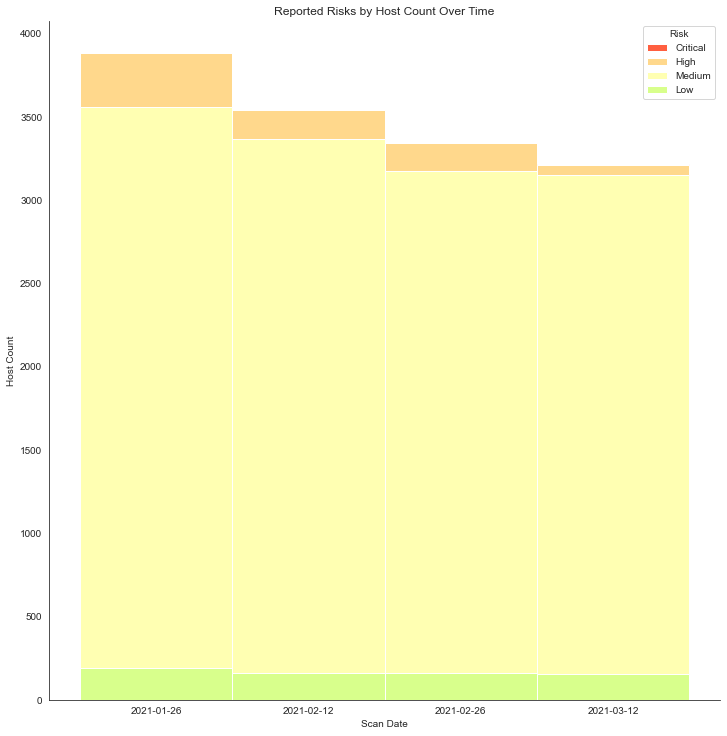

In [23]:
sns.set_style('white', {'legend.frameon':True})

#colors = Critical, High, Medium, Low
colors = ["#FF2A00","#FFCC66","#FFFF99","#CCFF66"]
sns.set_palette(sns.color_palette(colors))

g = sns.FacetGrid(df, height=10)
g.set_axis_labels("Scan Date", "Host Count")
g = sns.histplot(data=df, x="Scan Date", hue="Risk", hue_order=["Critical", "High", "Medium", "Low"], multiple="stack").set_title('Reported Risks by Host Count Over Time')